# Algorithm to identify Collusive Behavior from Emails

## Import required libraries

In [22]:
import email
import os
import numpy as np
import pandas as pd
from email import message_from_file
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import re
import nltk
from nltk.tokenize import word_tokenize
from textblob import Word
from sklearn.feature_extraction.text import TfidfVectorizer

## Read emails

Read emails and create a datframe with Subject,To,From,Date,Text columns

In [144]:
def retrieve(m, key):
    Text = ""
    Files = {}
    Parts = 0
    Html = ""
    if not m.is_multipart():
        if m.get_filename(): 
            fn = m.get_filename()
            print(fn)
            cfn = construct_name(key, fn)
            printnt(cfn)
            Files[fn] = (cfn, None)
            if file_exists(cfn): return Text, Html, Files, 1
            save_file(cfn, m.get_payload(decode=True))
            return Text, Html, 1
        cp = m.get_content_type()
        if cp=="text/plain": Text += m.get_payload()
        elif cp=="text/html": Html += m.get_payload(decode=True)
        return Text, Html, 1
    y = 0
    while 1:
        try:
            pl = m.get_payload(y)
        except: break
        t, h, f, p = retrieve(pl, key)
        Text += t; Html += h; Files.update(f); Parts += p
        y += 1
    return Text, Html, Parts


def caption (origin):
    Date = ""
    if 'date' in origin: Date = origin["date"].strip()
    From = ""
    if 'from' in origin: From = origin["from"].strip()
    To = ""
    if 'to' in origin: To = origin["to"].strip()
    Subject = ""
    if 'subject' in origin: Subject = origin["subject"].strip()
    return From, To, Subject, Date

In [6]:
df= pd.DataFrame(columns=['Subject','From','To','Date','Text'])
path = 'C:\\Analytics_Test_Task\\Communication_samples\\emails\\3_maildir\\allen-p\\inbox'
listing = os.listdir(path)

for fle in listing:
    fle = os.path.join(path, fle)
    if str.lower(fle[-3:])=="eml":
        m = email.message_from_file(open(fle))
        From, To, Subject, Date = caption(m)
        Text, Html, Files, Parts = retrieve(m,m.as_string)
        Text = Text.strip(); Html = Html.strip()
        msg = {"Subject": Subject, "From": From, "To": To, "Date": Date,
            "Text": Text}    
        df =df.append(msg,ignore_index= True)     

## Clean Email Text Data 

In [16]:
remove_list = []
def clean_sentence(text):   
    try:
        text = str(text)
        stopwords = set(STOPWORDS)
        new_words = ["using", "show", "result", "will", "also", "use", "us", "image", "make","please","one","still",
                    'thanks', 'regards','to','subject','sent','original', 'message']
        stopwords = stopwords.union(new_words)
        pattern = r'[^a-zA-Z/,:\s]'         
        text= re.sub(pattern, '', text)
        text = re.sub('[-,/:\s+]',' ',text)
        text = text.lower()
        word_tokens = word_tokenize(text)     
        filtered_sentence = [w for w in word_tokens if not w in stopwords]
        return " ".join(word for word in filtered_sentence)
    except Exception as ex:
        template = "An exception of type {0} occurred. \nArguments: {1!r}"
        message = template.format(type(ex).__name__, ex.args)
        print(message)   
        
def get_domain(email_address_from, email_address_to):
    from_domain_list , to_domain_list = ([] for i in range(2))
    email_from = email_address_from.split(',')
    email_to = email_address_to.split(',')
    if email_address_from:
        for mail_f in email_from:
            from_domain_list.append(mail_f.split('@')[1])
    if email_address_to:
        for mail_t in email_to:
            to_domain_list.append(mail_t.split('@')[1])
    from_domain = set(from_domain_list)
    to_domain = set(to_domain_list)
    if(from_domain == to_domain):
        return("Same Domain")
    else:
        return("Different Domain")

In [17]:
df['Clean_Text']= df.apply(lambda row: clean_sentence(row['Text']),axis=1)
# remove word with lenght shorter that 2 character
df['Clean_Text'] = df['Clean_Text'].apply(lambda sentence: ' '.join(filter(lambda word: len(word) > 2, sentence.split())))
#Lemmatization
df['Clean_Text'] = df['Clean_Text'].apply(lambda x: " ".join([Word(word).lemmatize(pos='v') for word in x.split()]))

## Identify the domains of email communication

Check if the communication in within the same or different domain

In [18]:
df['Domain'] = df.apply(lambda row: get_domain(row['From'],row['To']),axis = 1)

## Ignore Emails from Promotional domains

In [19]:
ignore_mails = ['anchordesk.zdlists.com','intelligencepress.com','amazon.com','networkpromotion.com',
               'feedback.iwon.com','sportsline.com']
for i in df.index:
    if(df.loc[i].From.split('@')[1] in(ignore_mails)):
        df= df.drop(index =i)

## Most frequent Words

In [145]:
freq = pd.Series(' '.join(df['Clean_Text']).split()).value_counts()[:20]

In [ ]:
#Generate a word cloud image
def generate_wordcloud(text_data):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words =50,collocations=False).generate(text_data)
    plt.figure(figsize=(7,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

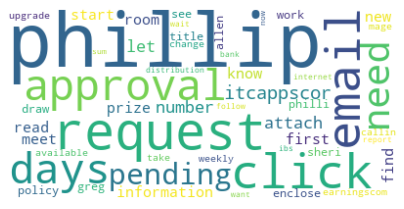

In [146]:
generate_wordcloud(str(df['Clean_Text']))

## Important words

In [130]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df_top = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df_top.features.tolist()

def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [114]:
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
X = vect.fit_transform(df.Clean_Text)
features = vect.get_feature_names()

In [133]:
list_words = []
for i in range(0,len(df)):
    val = top_feats_in_doc(X, features, i, 10)
    list_words.append(val)

In [136]:
df["Word"] = list_words

## Words that indicate collusive behavior or some stress

In [139]:
# This list needs to be ammended from time to time 
word_list = ['cash','bond','price','joint']

## Check from the Word list in dataframe if it contains any words from the above list, then we can say that the communication might show some collusive behavior

## SMS

In [154]:
from bs4 import BeautifulSoup
import requests

In [155]:
url = "C:/sms1.html"
page = open(url)

In [156]:
page

<_io.TextIOWrapper name='C:/sms1.html' mode='r' encoding='cp1252'>

In [157]:
soup = BeautifulSoup(page.read())

In [181]:
abstract = soup.select('div[class="content"]')

In [159]:
temp = abstract[0]

In [160]:
temp.contents[0]

'\n                    Sms #2\n                '